In [ ]:
# Librerías estándar y manipulación de archivos
import os
import joblib
import json
import pickle

# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.animation import FuncAnimation

# Reducción de dimensionalidad
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Técnicas de balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.pipeline import Pipeline

# Configuraciones adicionales
import warnings

# Se ignoran los warnings en el notebook
warnings.filterwarnings('ignore')

# **3- Carga de datos tras EDA - Hipótesis P6B: edad (12, 17]**

In [ ]:
# Carga de los datos obtenido tras el EDA
med_app_EDA = pd.read_csv('med_app_FE.csv')
med_app_FE = med_app_EDA.copy()

# Filtrar los datos donde Age sea mayor que 12 y menor o igual a 17
med_app_FE = med_app_FE[(med_app_FE['Age'] > 12) & (med_app_FE['Age'] <= 17)]

# Al cargar los datos se pierden cierto tipos de datos establecido en el EDA, a continuación se corrigen
med_app_FE['ScheduledDay'] = pd.to_datetime(med_app_FE['ScheduledDay']).dt.tz_localize(None)
med_app_FE['AppointmentDay'] = pd.to_datetime(med_app_FE['AppointmentDay']).dt.tz_localize(None)
med_app_FE['Gender'] = med_app_FE['Gender'].astype('int32')
med_app_FE['App_DayOfWeek'] = med_app_FE['App_DayOfWeek'].astype('int32')
med_app_FE['Neighbourhood'] = med_app_FE['Neighbourhood'].astype('int32')

In [ ]:
# Número de pacientes únicos
NUMBER_PATIENTS = med_app_FE['PatientId'].nunique()
print('Variable NUMBER_PATIENTS: ', NUMBER_PATIENTS)

# Distribución de NoShow igual a 1
class_counts = med_app_FE['NoShow'].value_counts()
NUMBER_NO_SHOWS = class_counts[1]
print('Variable NUMBER_NO_SHOWS: ', NUMBER_NO_SHOWS)

# Numero de filas
NUMBER_SAMPLES = med_app_FE.shape[0]
print('Variable NUMBER_SAMPLES: ', NUMBER_SAMPLES)

Variable NUMBER_PATIENTS:  3602
Variable NUMBER_NO_SHOWS:  1690
Variable NUMBER_SAMPLES:  6342


In [ ]:
med_app_FE.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6342 entries, 4 to 110474
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PatientId                6342 non-null   int64         
 1   AppointmentID            6342 non-null   int64         
 2   Gender                   6342 non-null   int32         
 3   ScheduledDay             6342 non-null   datetime64[ns]
 4   AppointmentDay           6342 non-null   datetime64[ns]
 5   App_DayOfWeek            6342 non-null   int32         
 6   Time_SchDay_to_AppDay    6342 non-null   int64         
 7   Days_since_last_App      6342 non-null   int64         
 8   Age                      6342 non-null   int64         
 9   Neighbourhood            6342 non-null   int32         
 10  Neigh_Cluster            6342 non-null   int64         
 11  Health_Centre            6342 non-null   int64         
 12  Temperature              6342 non-nul

## 3.1 Visualización de la **matriz de correlación** entre todas las variables, incluída la Target.

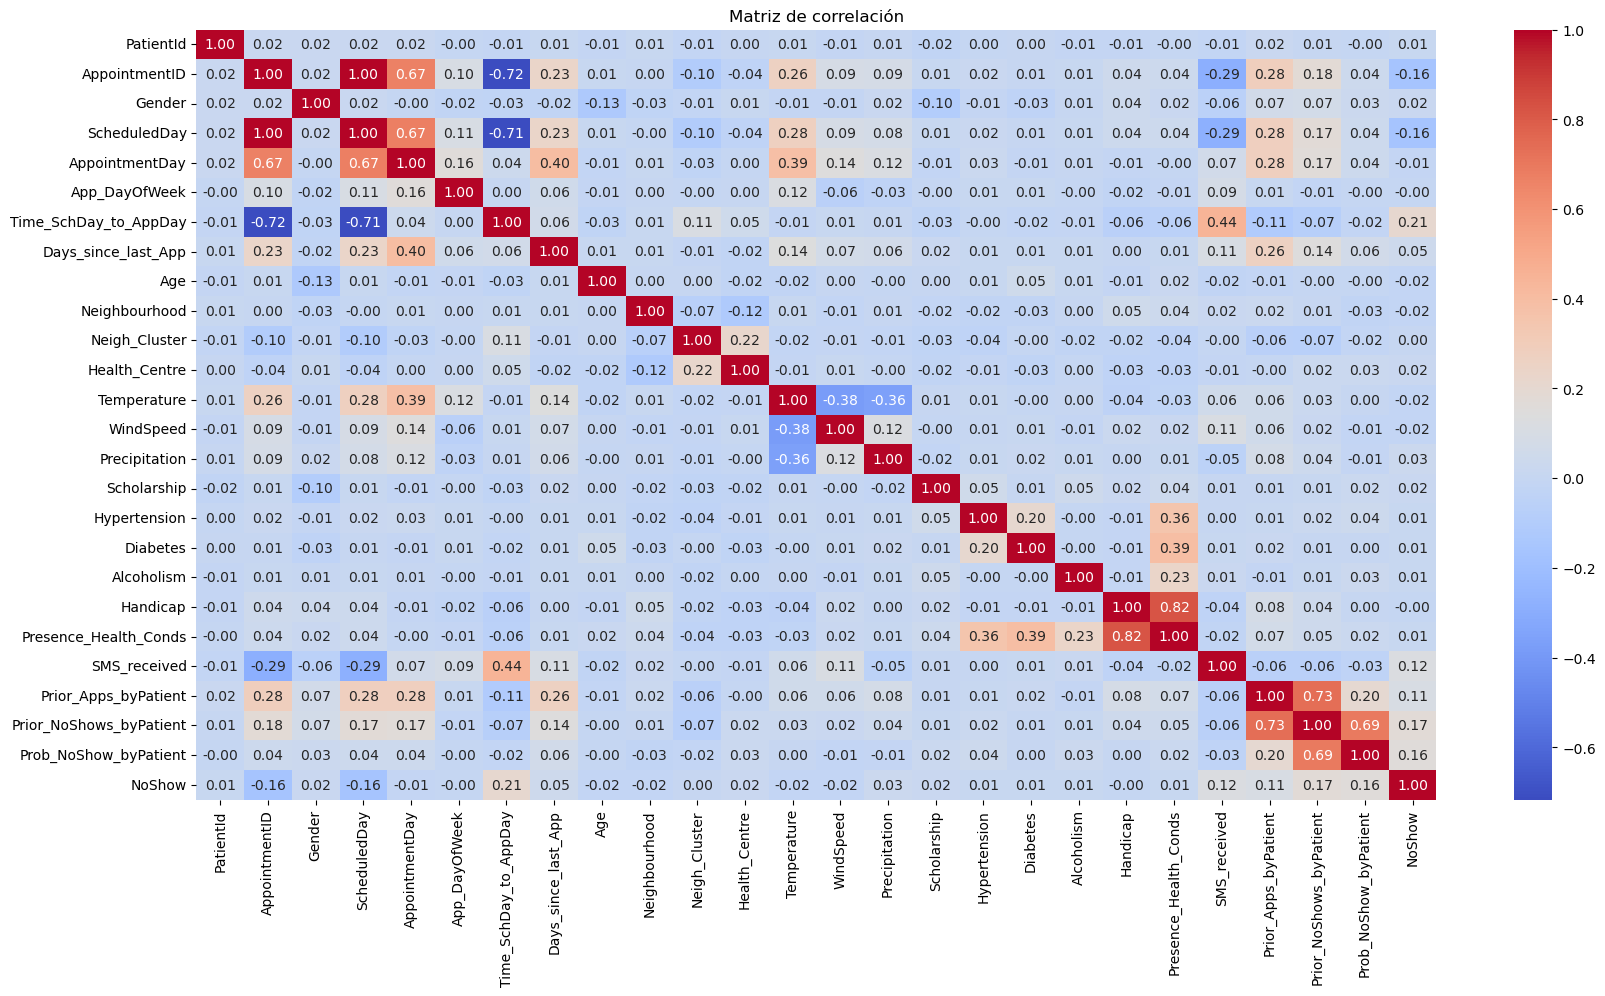

In [ ]:
# Cálculo de la matriz de correlación
correlation = med_app_FE.corr()

# Visualización de la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

# **4- Conformación de los sets de entrenamiento y prueba**

## 4.1 División del dataset en los conjuntos de entrenamiento y prueba

La estructura del dataset Medical Appointments contiene un fuerte componente temporal, con la información de los pacientes que van asistiendo de forma regular a consulta médica.

Se divide el dataset de forma que el set de prueba corresponda sólo a las últimas citas de pacientes distintos, intentando que todos ellos tengan las citas asignadas al final del periodo temporal que comprende el dataset, manteniendo la misma estratificación de clases que en el dataset original.

In [ ]:
NUMBER_Apps_inTest = int(NUMBER_SAMPLES * 0.20)
print(f"Para alcanzar el 20% del muestreo en nuestro set de pruebas\n \
necesitamos {NUMBER_Apps_inTest} citas de pacientes distintos, es decir,\n \
muestras de un {NUMBER_Apps_inTest / NUMBER_PATIENTS:.2%} de los pacientes.")

Para alcanzar el 20% del muestreo en nuestro set de pruebas
 necesitamos 1268 citas de pacientes distintos, es decir,
 muestras de un 35.20% de los pacientes.


In [ ]:
# Creación del sub-dataset que contiene sólo la última cita de cada paciente
last_app_byPatient = med_app_FE.groupby('PatientId').last()

# Ordenación por 'AppointmentDay'
last_app_byPatient = last_app_byPatient.sort_values(by = 'AppointmentDay')

# Cálculo del número de citas NoShow = True que se requieren para mantener la estratificación de Clases
NUMBER_NoShows_inTest = int(NUMBER_Apps_inTest * (NUMBER_NO_SHOWS / NUMBER_SAMPLES))
NUMBER_Shows_inTest = int(NUMBER_Apps_inTest - NUMBER_NoShows_inTest)
print(f"Se requieren {NUMBER_NoShows_inTest} pacientes con 'NoShow' = True en el Set de Prueba, y\n \
{NUMBER_Shows_inTest} pacientes con 'NoShow' = False.\n")

# Selección de las últimas 4463 muestras del sub-dataset 'last_app_byPatient' con 'NoShow' = True
test_set_NoShows = last_app_byPatient[last_app_byPatient['NoShow'] == True][-(NUMBER_NoShows_inTest+1):-1]

# Selección de las últimas 17642 muestras del sub-dataset 'last_app_byPatient' con 'NoShow' = False
test_set_Shows = last_app_byPatient[last_app_byPatient['NoShow'] == False][-(NUMBER_Shows_inTest+1):-1]

# Concatenación de ambos sub-dataset en el Set de Pruebas
test_set = pd.concat([test_set_NoShows, test_set_Shows])

# Selección del Set de Pruebas definitivo
test_set = med_app_FE[med_app_FE['AppointmentID'].isin(test_set['AppointmentID'])]
print(f"Creado Set de Prueba con {test_set.shape[0]} citas de \
{test_set['PatientId'].nunique()} pacientes distintos.")

# Selección del Set de Entrenamiento definitivo
train_set = med_app_FE[~med_app_FE['AppointmentID'].isin(test_set['AppointmentID'])]
print(f"Creado Set de Entrenamiento con {train_set.shape[0]} citas de \
{train_set['PatientId'].nunique()} pacientes distintos.")

Se requieren 337 pacientes con 'NoShow' = True en el Set de Prueba, y
 931 pacientes con 'NoShow' = False.

Creado Set de Prueba con 1268 citas de 1268 pacientes distintos.
Creado Set de Entrenamiento con 5074 citas de 3029 pacientes distintos.


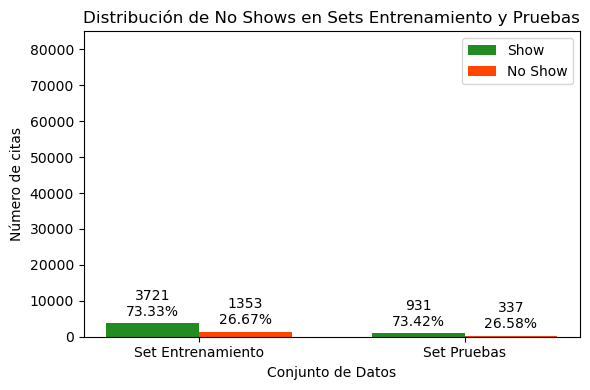

In [ ]:
# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y de las barras
width = 0.35
offsets = np.linspace(-width/2, width/2, 2)

labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']

def create_bars(datasets):
    for pos, dataset in enumerate(datasets):
        class_counts = dataset['NoShow'].value_counts()
        rects_list = []
        for i, counts in enumerate(class_counts.values):
            rects_list.append(ax.bar(x = pos + offsets[i],
                                    height = counts,
                                    width = width,
                                    color = colors[i]))
            if pos == 1:  # Solo añadir la leyenda en la primera iteración
                rects_list[-1].set_label(labels[i])
            height = int(rects_list[i].datavalues)
            total_height = dataset.shape[0]
            ax.annotate(f'{height}\n{height/total_height:.2%}',
                        xy = (pos + offsets[i], height),
                        xytext = (0, 25), textcoords = "offset points",
                        ha = 'center', va = 'top')
    return

create_bars([train_set, test_set])

# Configuración de ejes y título
ax.set_xlabel('Conjunto de Datos')
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows en Sets Entrenamiento y Pruebas")
ax.set_xticks([0, 1], ['Set Entrenamiento', 'Set Pruebas'])
ax.legend(loc='upper right')
ax.set_ylim(0, 85000)

plt.tight_layout()
plt.show()

## 4.2 Eliminación de las variables que no aportan información relevante

Se considera que las siguientes variables no contienen información relevante, por los motivos expuestos:

- **'AppointmentID'**: Número diferente asignado a cada cita, en función de la fechas de programación de cita.

  - *La correlación que se observa con la variable Target 'NoShows' (-0.16) es directamente proporcional a la correlación existente entre la diferencia de tiempo entre el 'AppointmentDay' y el 'ScheduledDay' ('Time_SchDay_to_AppDay') con 'NoShows', ya que las primeras citas programadas son las que tienen los números AppointmentID más bajos, y éstas coinciden con las que tienen el 'Time_SchDay_to_AppDay' más alto.*

- **'PatientId'**: Número diferente asignado a cada paciente. Dicho número es aleatorio.

- **ScheduledDay** y **'AppointmentDay**: Día de programación de la cita y de día de asignación de cita, respectivamente.

  - *Con el Feature Engineering ya se ha guardado toda la información relevante que contienen estas fechas*

- **'Neighbourhood'**: Barrio de residencia de cada paciente.

  - *Esta información ya se ha agrupado en la variable 'Neigh_Cluster'.*

- **SMS_received**: Variable que guarda información sobre la recepción o no de SMS recordatorio de asistencia a la cita, para cada cita.

  - *El envío de SMS's recordatorios es importante para disminuir las ausencias, pero no lo podemos usar como variable predictora en el algoritmo de predicción, ya que no se dispondrá dicha información en el momento de programación de la cita.*

In [ ]:
# Definición de las variables que no aportan información:
columns_to_drop = ['AppointmentID',
                    'PatientId',
                    'ScheduledDay',
                    'AppointmentDay',
                    'Neighbourhood',
                    'SMS_received']

# En el set de entrenamiento:
train_set.drop(columns = columns_to_drop, inplace = True)
# En el set de pruebas:
test_set.drop(columns = columns_to_drop, inplace = True)

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5074 entries, 4 to 110473
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   5074 non-null   int32  
 1   App_DayOfWeek            5074 non-null   int32  
 2   Time_SchDay_to_AppDay    5074 non-null   int64  
 3   Days_since_last_App      5074 non-null   int64  
 4   Age                      5074 non-null   int64  
 5   Neigh_Cluster            5074 non-null   int64  
 6   Health_Centre            5074 non-null   int64  
 7   Temperature              5074 non-null   float64
 8   WindSpeed                5074 non-null   float64
 9   Precipitation            5074 non-null   float64
 10  Scholarship              5074 non-null   int64  
 11  Hypertension             5074 non-null   int64  
 12  Diabetes                 5074 non-null   int64  
 13  Alcoholism               5074 non-null   int64  
 14  Handicap                 50

In [ ]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1268 entries, 53 to 110474
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   1268 non-null   int32  
 1   App_DayOfWeek            1268 non-null   int32  
 2   Time_SchDay_to_AppDay    1268 non-null   int64  
 3   Days_since_last_App      1268 non-null   int64  
 4   Age                      1268 non-null   int64  
 5   Neigh_Cluster            1268 non-null   int64  
 6   Health_Centre            1268 non-null   int64  
 7   Temperature              1268 non-null   float64
 8   WindSpeed                1268 non-null   float64
 9   Precipitation            1268 non-null   float64
 10  Scholarship              1268 non-null   int64  
 11  Hypertension             1268 non-null   int64  
 12  Diabetes                 1268 non-null   int64  
 13  Alcoholism               1268 non-null   int64  
 14  Handicap                 1

## 4.3 Se guarda la información de los Sets de Entrenamiento y Prueba, antes de separar etiquetas, estandarizar y balancear con SMOTE+ENN

In [ ]:
# Exportar el DataFrame a archivos csv
train_set.to_csv('train_set_P6B-ADOLESCENTS.csv', index=False)
test_set.to_csv('test_set_P6B-ADOLESCENTS.csv', index=False)

# Exportar el DataFrame a archivo Excel
train_set.to_excel('train_set_P6B-ADOLESCENTS.xlsx', index=False)
test_set.to_excel('test_set_P6B-ADOLESCENTS.xlsx', index=False)

## 4.4 División de las variables predictoras de la variable target (etiquetas)

In [ ]:
# Se divide el conjunto de entrenamiento en características y etiquetas
X_train_set = train_set.drop('NoShow', axis=1)
y_train_set = train_set['NoShow']
X_test_set = test_set.drop('NoShow', axis=1)
y_test_set = test_set['NoShow']

# **5- Últimas transformaciones de los datasets antes del entrenamiento**

## 5.1 Estandarización de las bases de datos

In [ ]:
# Guardar los nombres de las columnas
column_names = X_train_set.columns

# Se crea una instancia de StandardScaler
scaler = StandardScaler()

# Se ajusta el escalador a los datos de entrenamiento y se transforman
X_train_scaled = scaler.fit_transform(X_train_set)
# Se transforman los datos de test utilizando el mismo escalador que se ajustó a los datos de entrenamiento
X_test_scaled = scaler.transform(X_test_set)

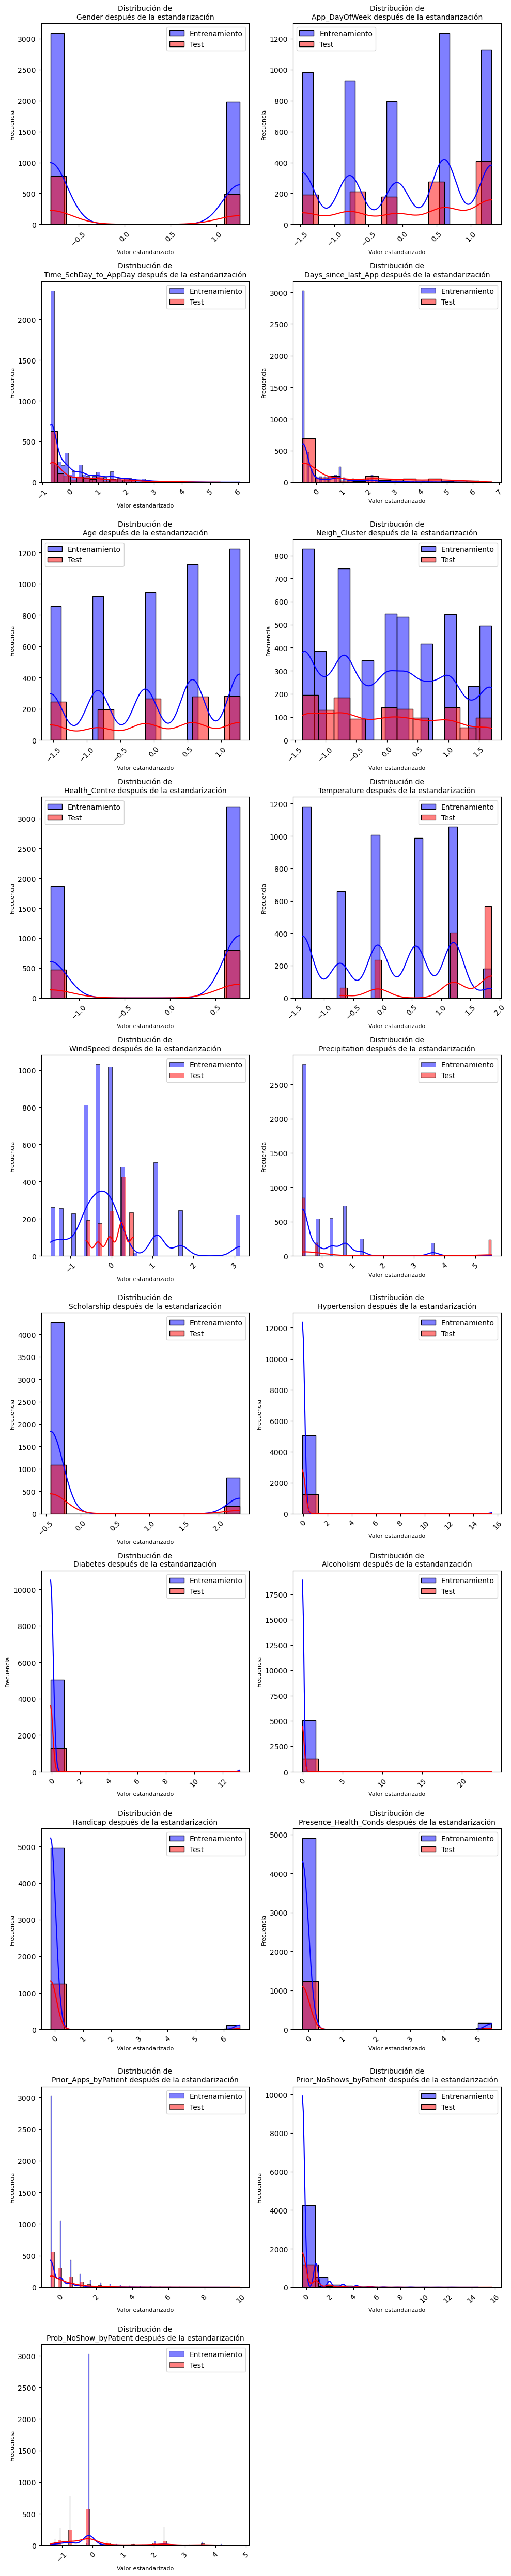

In [ ]:
# Convertir los resultados a DataFrame para facilitar la manipulación y visualización,
# utilizando los nombres de las columnas guardados previamente
X_train_df = pd.DataFrame(X_train_scaled, columns = column_names)
X_test_df = pd.DataFrame(X_test_scaled, columns = column_names)

# Número de características en el DataFrame
num_features = X_train_df.shape[1]

# Número de columnas para los sub-gráficos
num_columns = 2

# Calcular el número de filas basado en el número de características y columnas
num_rows = num_features // num_columns + (num_features % num_columns > 0)


# Crear una figura grande para acomodar todos los sub-gráficos
plt.figure(figsize=(10, 5 * num_rows))

# Crear un histograma para cada característica
for i in range(num_features):
    plt.subplot(num_rows, num_columns, i+1)

    # Histograma de los datos de entrenamiento en azul
    sns.histplot(X_train_df.iloc[:, i], kde=True, color='blue', alpha=0.5, label='Entrenamiento')

    # Histograma de los datos de test en rojo
    sns.histplot(X_test_df.iloc[:, i], kde=True, color='red', alpha=0.5, label='Test')

    # Usar un salto de línea para dividir el título en dos líneas
    plt.title(f'Distribución de\n{column_names[i]} después de la estandarización', fontsize=10)

    plt.xlabel('Valor estandarizado', fontsize=8)
    plt.ylabel('Frecuencia', fontsize=8)
    plt.xticks(rotation=45)
    plt.legend()

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

## 5.2 DATA AUGMENTATION para balancear las clases en el dataset de entrenamiento (**SMOTE** y **EDITED NEAREST NEIGHBOURS**)

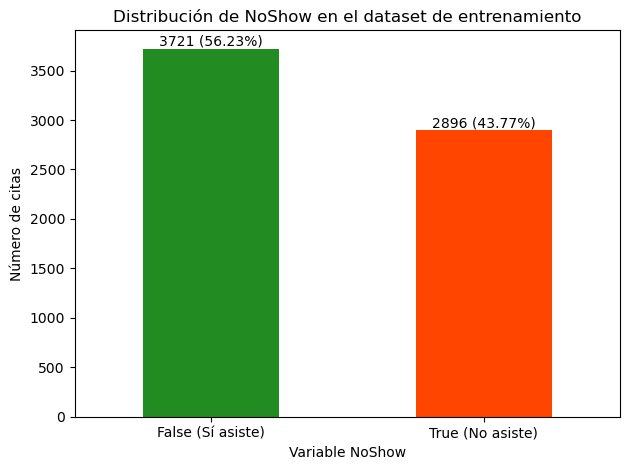

In [ ]:
# Se crea una instancia de SMOTE y ENN
smote = SMOTE(sampling_strategy = 'minority',
                random_state = 42)
enn = EditedNearestNeighbours(sampling_strategy = 'not minority',
                                kind_sel = 'all',
                                n_neighbors = 2)

# Se crea una instancia de la clase Pipeline
pipeline = Pipeline([('smote', smote), ('enn', enn)])

# Se aplica el pipeline a los datos
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_scaled, y_train_set)

# Distribución del dataset posterior a la aplicación de SMOTE-ENN
class_counts = y_train_resampled.value_counts()

# Se define el gráfico con los parámetros adicionales solicitados
class_counts.plot(kind='bar', rot=0, color=['forestgreen', 'orangered'])

# Se añaden etiquetas y título al gráfico
plt.xlabel('Variable NoShow')
plt.ylabel('Número de citas')
plt.title('Distribución de NoShow en el dataset de entrenamiento')

# Se añaden los porcentajes en las barras
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(X_train_resampled) * 100:.2f}%)', ha='center', va='bottom')

# Se establecen las etiquetas en el eje X
plt.xticks([0, 1], ['False (Sí asiste)', 'True (No asiste)'])

# Se muestra el gráfico
plt.tight_layout()
plt.show()

## 5.3 Reducción de dimensionalidad (**PCA**)

In [ ]:
# Aplicar PCA para reducir la dimensionalidad mientras se conserva la mayor cantidad de varianza posible
pca = PCA(n_components = 0.95,
            svd_solver = 'full')

# Ajustar y transformar los datos de entrenamiento
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

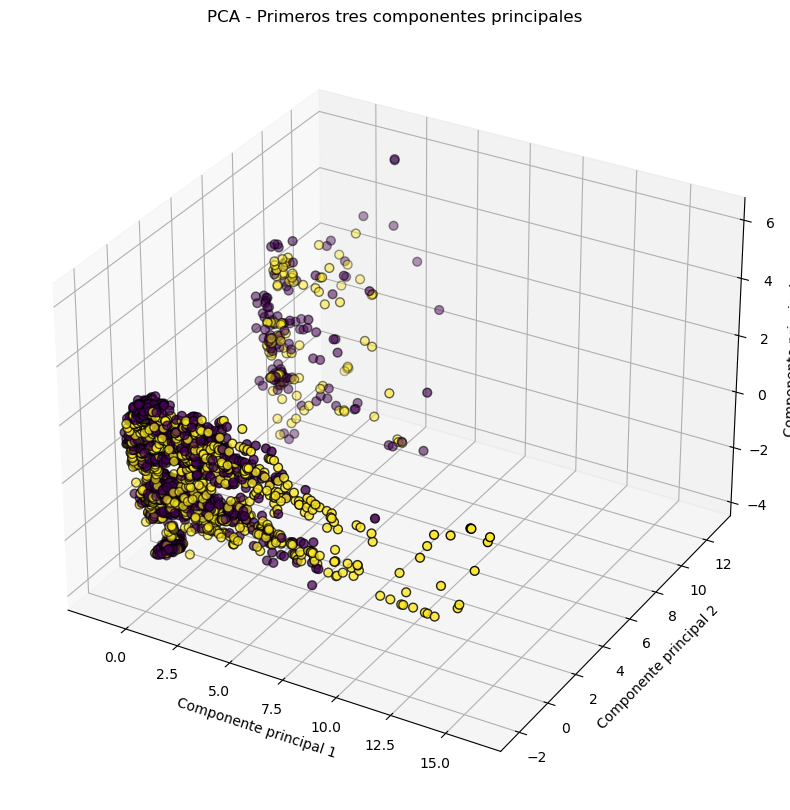

Número de componentes: 16
Varianza explicada por cada componente: [0.14650098 0.10652917 0.0903405  0.07262182 0.06415176 0.06104938
 0.05476192 0.05104744 0.04964889 0.04938581 0.04609829 0.04223016
 0.0395102  0.03637183 0.03442625 0.0335082 ]
Varianza total explicada: 0.9781826072025968


In [ ]:
# Gráfico de los primeros tres componentes principales en un gráfico 3D
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0],
            X_train_pca[:, 1],
            X_train_pca[:, 2],
            c = y_train_resampled,
            cmap = 'viridis',
            edgecolor = 'k',
            s = 40)

ax.set_title('PCA - Primeros tres componentes principales')
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')
plt.show()

# Imprimir la cantidad de componentes y la varianza explicada
print(f"Número de componentes: {pca.n_components_}")
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada: {np.sum(pca.explained_variance_ratio_)}")

## 5.4 Se guarda la información de los Datasets de Entrenamiento y Pruebas (**sin aplicar PCA**)

In [ ]:
# Exportar los datos de entrenamiento y test en archivos pkl
with open('X_train_P6B-ADOLESCENTS.pkl', 'wb') as file:
    pickle.dump(X_train_resampled, file)
# Guardar y_train
with open('y_train_P6B-ADOLESCENTS.pkl', 'wb') as file:
    pickle.dump(y_train_resampled, file)
# Guardar X_test
with open('X_test_P6B-ADOLESCENTS.pkl', 'wb') as file:
    pickle.dump(X_test_scaled, file)
# Guardar y_test
with open('y_test_P6B-ADOLESCENTS.pkl', 'wb') as file:
    pickle.dump(y_test_set, file)